In [1]:
import pandas as pd
from gensim.models import Word2Vec
from termcolor import colored
import warnings
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")
%matplotlib inline

## Helper functions & setup

In [2]:
#Using the Google News Model
#not pushed because it is too big but can be found here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
model = Word2Vec.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
#I will be using the first folder as my data
queries_file = open("../data/user_studies/all.txt", "r")
lines = queries_file.readlines()
lines = [l.strip() for l in lines]
# remove all strings with length < 3
queries = []
for i in lines:
    if not len(i)<3:
        queries.append(i)

In [4]:
#helper functions
def get_sentence_vector(q):
    """returns the vector for a sentence"""
    #remove all punctuation from query
    q = re.sub(r'[^\w\s]','',q)
    #split by word
    q = q.split(" ")
    # remove extra spaces
    q = [i.strip() for i in q]
    query_vec = np.zeros(300)
    #adds the vectors of all individual words to get
    for w in q:
        try:
            query_vec+=model[w]
        except KeyError:
            pass
    return query_vec

#Get results based on query number
def get_results(q_num):
    filename = "../data/user_studies/results_"+str(q_num)+".txt"
    f = open(filename, "r")
    lst = f.readlines()
    lst = [i.split("--") for i in lst]
    lst = list(zip(*lst))
    scores = [float(i.strip()) for i in lst[0]]
    results = [i.strip() for i in lst[1]]
    return scores, results

In [5]:
query_number=3
query = queries[query_number]
scores, results = get_results(query_number)
query

'well ... last night was uneventful ... really got to know the next door neighbor'

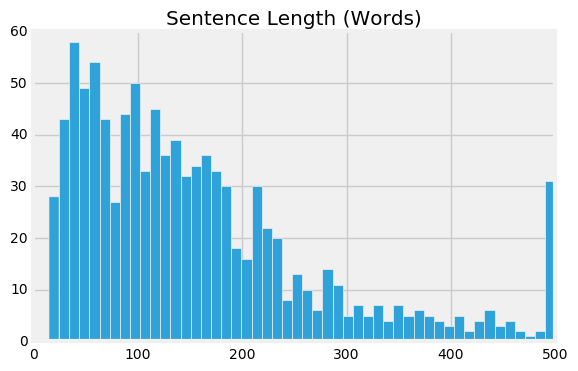

Percent of sentences with word length greater than 50 is 84.0 %


In [6]:
#distribution of the length of the sentences in the query results
sentence_lengths = np.array([len(x.split(" ")) for x in results])
plt.title("Sentence Length (Words)")
plt.hist(sentence_lengths, bins=50)
plt.show()
print("Percent of sentences with word length greater than 50 is", 
      np.count_nonzero(sentence_lengths>50)/len(sentence_lengths)*100, "%")

## Clustering results

In [7]:
#make a distance matrix in which you take pairwise similairties between
dist_matrix = np.zeros([1000, 1000])
vectors  = [get_sentence_vector(x) for x in results]
dist_matrix = 1-cosine_similarity(vectors, vectors) # 1-cosine similarity to be more intuitive when using as a distance
dist_matrix

array([[ -4.44089210e-16,   1.87773362e-01,   7.76616112e-02, ...,
          1.10465825e-01,   1.23730299e-01,   1.38357308e-01],
       [  1.87773362e-01,   4.44089210e-16,   1.63489893e-01, ...,
          1.86663244e-01,   1.68457161e-01,   1.48352546e-01],
       [  7.76616112e-02,   1.63489893e-01,   4.44089210e-16, ...,
          9.68487694e-02,   1.05735311e-01,   1.20716608e-01],
       ..., 
       [  1.10465825e-01,   1.86663244e-01,   9.68487694e-02, ...,
          4.44089210e-16,   7.76663372e-02,   7.39671201e-02],
       [  1.23730299e-01,   1.68457161e-01,   1.05735311e-01, ...,
          7.76663372e-02,  -2.22044605e-16,   8.40540226e-02],
       [  1.38357308e-01,   1.48352546e-01,   1.20716608e-01, ...,
          7.39671201e-02,   8.40540226e-02,   0.00000000e+00]])

In [8]:
il1 = np.tril(dist_matrix, -1)
lower_triangle = dist_matrix[il1>0]
lower_triangle

array([ 0.18777336,  0.07766161,  0.16348989, ...,  0.0846858 ,
        0.07396712,  0.08405402])

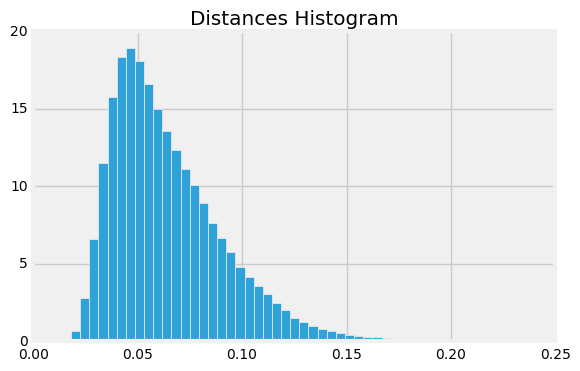

In [9]:
#distribution of distances for the first 1000 query results
plt.hist(lower_triangle, bins=50, normed=True)
plt.title("Distances Histogram")
plt.show()

In [10]:
#pick a small epsilon to draw an edge between results
epsilon = np.percentile(lower_triangle, 3)
epsilon

0.029357495826176055

In [11]:
#make a list of edges from the adjacency matrix
import networkx as nx
edges = []
adj_matrix = dist_matrix<epsilon #make adjacency matrix
for i in range(1000):
    for j in range(1000):
        if adj_matrix[i, j] and i!=j:
            edges.append((i,j))
G = nx.Graph(edges)
#number of connected components in Graph
len(list(nx.connected_components(G)))

1

In [12]:
#investigate the degrees of each node
G.degree()

{3: 116,
 7: 7,
 11: 7,
 12: 56,
 13: 4,
 14: 14,
 15: 85,
 17: 7,
 22: 1,
 24: 6,
 25: 1,
 28: 38,
 30: 5,
 31: 53,
 32: 29,
 33: 97,
 35: 51,
 40: 111,
 46: 47,
 48: 3,
 49: 5,
 50: 14,
 53: 168,
 57: 145,
 58: 62,
 59: 44,
 60: 174,
 63: 7,
 65: 10,
 68: 86,
 70: 21,
 71: 282,
 73: 37,
 74: 6,
 76: 2,
 77: 123,
 82: 15,
 83: 122,
 85: 1,
 88: 70,
 90: 17,
 92: 90,
 94: 38,
 103: 9,
 104: 10,
 106: 52,
 109: 2,
 110: 187,
 111: 9,
 114: 21,
 115: 27,
 116: 17,
 117: 88,
 120: 6,
 122: 6,
 124: 8,
 125: 17,
 133: 62,
 134: 64,
 135: 110,
 139: 25,
 144: 225,
 145: 105,
 146: 128,
 147: 12,
 148: 1,
 150: 41,
 152: 1,
 155: 13,
 156: 99,
 158: 2,
 160: 60,
 162: 104,
 163: 60,
 168: 66,
 170: 1,
 172: 77,
 173: 10,
 174: 219,
 175: 226,
 176: 10,
 178: 7,
 179: 108,
 180: 58,
 181: 237,
 187: 5,
 189: 18,
 193: 151,
 195: 148,
 198: 4,
 199: 16,
 200: 9,
 201: 4,
 202: 26,
 203: 145,
 205: 240,
 207: 81,
 208: 137,
 212: 106,
 215: 156,
 220: 1,
 221: 184,
 222: 15,
 226: 52,
 228: 62,

In [13]:
#remove all the vertices with a degree of 80 or more 
low_degree = [x  for x, v in G.degree().items() if v<80]
high_degree = [x  for x, v in G.degree().items() if v>=80]
most_connected_sentences = np.array(results)[high_degree]
H = G.subgraph(low_degree)
len(high_degree)

146

In [14]:
#makes json which is important for graph visualization
# Now you can go and fire up index.html in the browser
import json

graph = {}
graph['nodes'] = [{'id': node, 'group': 1, 'text':results[node]} for node in H.nodes()]
graph['links'] = [{'source': i, 'target': j, 'value': 1} for (i,j) in H.edges()]

   
f = open('graph.json', 'w')
f.write(json.dumps(graph))
f.close()

In [15]:
#number of edges and vertices in subgraph
len(H.edges()), len(H.nodes())

(866, 388)

## Finding meaning within clusters

In [16]:
from community import community_louvain
#this looks more like the partition the the code in js gives as opposed to best_partition
d = community_louvain.generate_dendrogram(H)
partition = community_louvain.partition_at_level(d, 2)

In [17]:
#make an array where in the ith position, we have a list of all the nodes belonging to that community
communities = [[]]*(max(partition.values())+1)
for node, com in partition.items():
    communities[com] = communities[com]+[node]

In [18]:
#community sizes
import pandas as pd
import nltk
pd.Series([len(x) for x in communities]).value_counts()

1     99
2      3
70     1
54     1
48     1
35     1
33     1
20     1
15     1
8      1
dtype: int64

In [19]:
#try to find some common keywords within communities
com5 = communities[4] #community of size 70

In [20]:
sentences_in_community = np.array(results)[com5]

In [21]:
from nltk.corpus import stopwords
from string import punctuation
import itertools

def clean_sentence(s):
    """Returns a list of all the words in a sentence with no stop words and no punctuation"""
    tokenized_sentence = [i.strip() for i in nltk.word_tokenize(s.lower())]
    words = [w for w in tokenized_sentence if w not in stopwords.words('english') and w not in punctuation]
    return words

#Find most relevant words

def make_dictionary(docs):
    """Takes in a list of documents and returns an alphabetically sorted list of all distinct words"""
    s = list(set(list(itertools.chain.from_iterable(docs))))
    s = list(sorted(s))
    return dict([(s[i], i) for i in range(len(s))])

def count_instances(map_, doc):
    """Counts instances words in docs given a dictionary"""
    count_array = np.zeros(len(map_.keys()))
    for word, index in map_.items():
        count_array[index] = doc.count(word)+1
    return count_array

def find_ngrams(input_list, n):
      if type(n)==list:
            lst = []
            for i in n:
                lst.extend(list(zip(*[input_list[j:] for j in range(i)])))
            return lst
      return list(zip(*[input_list[i:] for i in range(n)]))

In [22]:
#Find most common words for cluster #4
sentences_in_cluster = np.array(results)[communities[4]]
ngrams = [find_ngrams(clean_sentence(i), [4,5]) for i in sentences_in_cluster]
dictionary = make_dictionary(ngrams)
a = np.ones(len(dictionary))
for s in ngrams:
    a+=count_instances(dictionary, s)
best_scored = np.argsort(a)[::-1]
rev_dict = dict(map(reversed, dictionary.items()))
[rev_dict[i] for i in best_scored[:10]]

[('...', 'came', 'home', '...'),
 ('...', 'came', 'home', 'went'),
 ('...', 'got', 'ready', '...'),
 ('...', 'yeah', '...', 'good'),
 ('home', 'around', 'ish', '...'),
 ('blah', 'blah', 'blah', '...'),
 ('...', 'came', 'home', '...', 'took'),
 ('...', 'went', 'home', '...'),
 ('...', 'lol', '...', 'went'),
 ('...', 'went', 'go', 'pick')]

In [23]:
#Find most common words for cluster #5
sentences_in_cluster = np.array(results)[communities[5]]
ngrams = [find_ngrams(clean_sentence(i), [4,5]) for i in sentences_in_cluster]
dictionary = make_dictionary(ngrams)
a = np.ones(len(dictionary))
for s in ngrams:
    a+=count_instances(dictionary, s)
best_scored = np.argsort(a)[::-1]
rev_dict = dict(map(reversed, dictionary.items()))
[rev_dict[i] for i in best_scored[:10]]

[('damn', 'damn', 'damn', 'damn'),
 ('...', 'got', 'home', 'around'),
 ('damn', 'damn', 'damn', 'damn', 'damn'),
 ('fun', '...', 'went', 'shawns'),
 ('...', 'bre', 'went', 'home'),
 ('came', 'back', 'house', 'went'),
 ('went', 'back', 'merediths', 'house'),
 ('went', 'back', 'taylors', 'house'),
 ('went', 'back', 'house', '...'),
 ('face', 'kenny', 'kept', 'pokin')]

## sklearn to the rescue + wordcloud implementation

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import operator

vectorizer = CountVectorizer(min_df=1, stop_words='english')
analyze = vectorizer.build_analyzer()

def top_ngrams(communities,cluster, n=20):
    """Input:
        communities: List of lists that contain indices corresponding to sentences in the original array
        cluster: integer, the cluster to inspect
        n: integer, number of most common """
    sentences = np.array(results)[communities[cluster]]
    ngrams = []
    for s in sentences:
        ngrams.extend(analyze(s))

    counts = Counter(ngrams)

    return sorted(counts.items(), key=operator.itemgetter(1))[::-1][:n]

def get_wordcloud_json(ngram):
    wordcloud = []
    for word, count in ngram:
        wordcloud.append({"text":word, "size":count})
    return wordcloud

In [33]:
wordcloud = get_wordcloud_json(top_ngrams(communities,8, n=50))
f = open('wordcloud.json', 'w')
f.write(json.dumps(wordcloud))
f.close()